# Decision Trees

## Objectives

- Describe the decision tree modeling algorithm
- Use attribute selection methods (like gini index or information gain/entropy) to build different trees
- Explain the pros and cons of decision trees
- Interpret the feature importances of a fitted decision tree model

## Decision Trees at a High Level

**Decision trees** are a supervised learning model that uses past data to form a graph/pathway which leads to the model making _decisions_ on its predictions.

Every time we make a decision, we split up, or *partition*, the data based on the features.

I like to think of decision trees as a bunch of forks in the road.

<a title="Jonathan Billinger / Fork in the road" href="https://commons.wikimedia.org/wiki/File:Fork_in_the_road_-_geograph.org.uk_-_1355424.jpg"><img width="512" alt="Fork in the road - geograph.org.uk - 1355424" src="https://upload.wikimedia.org/wikipedia/commons/7/71/Fork_in_the_road_-_geograph.org.uk_-_1355424.jpg"></a>

#### A broader summary:

Decision trees are a highly interpretable<sup>1</sup>, easy-to-overfit type of model. They are best for modeling datasets where the relationship between the features and the target can be represented well with "if-this-then-this" type of statements. They will be the basis for one of the most popular ensemble methods: random forests.

A decision tree is a machine learning model that works by *partitioning* our sample space in a hierarchical way.

How do we partition the space? The key idea is that some attributes provide more *information* than others when trying to make a decision.

<sup>1</sup>_"Highly interpretable" matters if you need to be able to explain how the model decided to classify a given record in a given way. Simpler models tend to be more interpretable._


## Simple Example of a Decision Tree

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# This data is a processed version of recent Austin Animal Shelter data
# Goal is to predict whether an animal is adopted
df = pd.read_csv("data/processed_shelter.csv")
df.head()

,is_dog,age_in_days,is_female,adoption
0,0,122,0,0
1,1,742,0,0
2,1,742,0,0
3,1,742,1,0
4,1,744,1,0


## Decision Trees by Hand

Without using any Python tools, we could try to develop a decision tree to determine the outcome for a given animal. Let's start with a simplified view of 10 samples from our dataset.

In [8]:
example_sample = df.sample(10, random_state=20)
example_sample

,is_dog,age_in_days,is_female,adoption
592,0,90,0,1
62,0,84,0,1
366,0,1115,0,0
403,0,307,1,0
874,0,100,1,1
443,1,69,0,1
58,1,428,1,1
820,1,282,0,1
116,0,367,0,0
533,1,311,1,0


In [9]:
example_sample.loc[example_sample['age_in_days']<300]['adoption']
# perfectly pure node

592    1
62     1
874    1
443    1
820    1
Name: adoption, dtype: int64

In [13]:
example_sample.loc[example_sample['age_in_days']>=300]['adoption']

366    0
403    0
58     1
116    0
533    0
Name: adoption, dtype: int64

We want to predict whether `adoption` is a 1 or a 0. Can we perfectly represent this with "if-then" statements?

#### Split on Dogs/Non-Dogs

Let's start with "if the animal is a dog" to split into 2 groups

In [11]:
dogs = example_sample[example_sample["is_dog"]==1]
dogs

,is_dog,age_in_days,is_female,adoption
443,1,69,0,1
58,1,428,1,1
820,1,282,0,1
533,1,311,1,0


In [12]:
non_dogs = example_sample[example_sample["is_dog"]==0]
non_dogs

,is_dog,age_in_days,is_female,adoption
592,0,90,0,1
62,0,84,0,1
366,0,1115,0,0
403,0,307,1,0
874,0,100,1,1
116,0,367,0,0


#### Assessment of Decision Tree After One Split

Initially we had 10 animals, 60% of which were adopted, 40% of which weren't

Now we have `dogs`, of which 3/4 were adopted, and `non_dogs`, of which 3/6 were adopted. If we guessed "adoption" for all dogs, and "not adoption" for all non-dogs, we would be correct the majority of the time (6/10) - not any better than a dumb model-less baseline of just always guessing 'adoption'...

Let's do another split.

#### Split on Age

Let's split each of the existing groups into 2 groups based on whether the animals are more than or less than 300 days old.

In [14]:
old_dogs = dogs[dogs["age_in_days"]>300]
old_dogs

,is_dog,age_in_days,is_female,adoption
58,1,428,1,1
533,1,311,1,0


In [15]:
young_dogs = dogs[dogs["age_in_days"]<=300]
young_dogs

,is_dog,age_in_days,is_female,adoption
443,1,69,0,1
820,1,282,0,1


In [16]:
old_non_dogs = non_dogs[non_dogs["age_in_days"]>300]
old_non_dogs

,is_dog,age_in_days,is_female,adoption
366,0,1115,0,0
403,0,307,1,0
116,0,367,0,0


In [17]:
young_non_dogs = non_dogs[non_dogs["age_in_days"]<=300]
young_non_dogs

,is_dog,age_in_days,is_female,adoption
592,0,90,0,1
62,0,84,0,1
874,0,100,1,1


#### Assessment of Decision Tree After Two Splits

Now we have four categories, based on two splits:

```
if (dog):
  --> if (age>300):   NOT ADOPTED (1/2 adopted)
  --> if (age<=300):  ADOPTED     (2/2 adopted)
if (not dog):
  --> if (age>300):   NOT ADOPTED (0/3 adopted)
  --> if (age<=300):  ADOPTED     (3/3 adopted)
```

So if we guessed the majority class for each category each time (randomly choosing a tie-breaker), we would guess:

 - All old dogs are not adopted
 - All young dogs are adopted
 - All old non-dogs are not adopted
 - All young non-dogs are adopted

...which would mean we got 9 right, 1 wrong on the dataset overall, i.e. an 90% accuracy.  Pretty good for a pretty simple model! Definitely a lot easier than hand-calculating a logistic regression model.

#### Reflection

If we wanted to keep going, to be able to get to 100% accuracy, we could further slice by `age_in_days` to get the right answers for those last one. But rather than get into that, let's think about what we just did, and whether it was optimal.

Was splitting on dog/non-dog the right choice for our first split?

But how would my partition be *best* split? And how do I really know that the second split is better than the first? Can I do better than intuition here?  

## Trees in More Detail: 

Here's a great visual explanation of how decision trees work in practice: http://www.r2d3.us/visual-intro-to-machine-learning-part-1/

Let's scroll through and discuss together!

## Decision Trees at a High Level

### High level - how does the Decision Tree algorithm work?

 - Make a *decision* (a split) based on some *metric* using the features
    - Data are split into partitions via *branches* or sub-trees
 - Continue on with each partition, and do more splits for each using the features within that partition/subtree
 - Repeat this process recursively for each child until one of these conditions is met:
    - You have reached a pure split: the leaf has only 1 class
    - There are no more remaining attributes to split on
    - You reach some *stopping condition* imposed to avoid overfitting
    
You can then make predictions on new rows data by passing them through the tree (along the forks in the road) until you arrive at a leaf node which predicts the class for each new row.

![](images/decision_leaf.webp)

### Important Terminology related to Decision Trees
Let’s look at the basic terminologies used with Decision trees:

- **Root Node:** It represents entire population or sample, aka the root of the tree (which is typically, and unintuitively, at the top of the representation of most decision trees)
- **Decision Node:** When a sub-node splits into further sub-nodes, then it is called a Decision node
- **Leaf / Terminal Node:** Nodes with no children (no further splits) are called Leaf or Terminal nodes
- **Pruning:** When we reduce the size of decision trees by removing nodes (opposite of Splitting), the process is called pruning
- **Branch / Sub-Tree:** A sub section of decision tree is called branch or sub-tree
- **Parent and Child Node:** A node, which is divided into sub-nodes is called parent node of sub-nodes, whereas sub-nodes are the child of parent nodes


## Attribute Selection Methods

The goal is to have our ultimate categories be fully "ordered" (for a binary dependent variable, we'd have the 1's in their own groups and the 0's in the other groups). 

### Entropy/Information Gain

One way to assess the value of a split is to measure how *disordered* our groups are, and there is a notion of ***entropy*** that measures precisely this.

The entropy of the whole dataset is given by:

$\large E = -\Sigma^n_i p_i\log_2(p_i)$,

where $p_i$ is the probability of belonging to the $i$th group, where $n$ is the number of groups (i.e. target values).

**Entropy will always be between 0 and 1. The closer to 1, the more disordered your group (bad).**

#### Information Gain

To calculate the entropy of a *split*, we're going to want to calculate the entropy of each of the groups made by the split, and then calculate a weighted average of those groups' entropies––weighted, that is, by the size of the groups.

In other words: for a given split, the **information gain** is simply the entropy of the parent group minus the entropy of the split.

> We can essentially say **information gain** is the **_difference_** of the **parent's entropy** and the **_average_** of the **children's entropy**

For a given parent, then, we maximize our model's performance by *minimizing* the split's entropy.


### Gini Impurity

An alternative metric to entropy comes from the work of Corrado Gini. The Gini Impurity is defined as:

$\large G = 1 - \Sigma_ip_i^2$, or, equivalently, $\large G = \Sigma_ip_i(1-p_i)$.

where, again, $p_i$ is the probability of belonging to the $i$th group.

**Gini Impurity will always be between 0 and 0.5. The closer to 0.5, the more disordered your group (bad).**

### Impurity Metric Caveat


As found in *Introduction to Data Mining* by Tan et. al:

> "Studies have shown that the choice of impurity measure has little effect on the performance of decision tree induction algorithms. This is because many impurity measures are quite consistent with each other [...]. Indeed, the strategy used to prune the tree has a greater impact on the final tree than the choice of impurity measure."

(AKA don't worry about your choice of Attribute Selection Method too much - but you should know what the tree is calculating and minimizing under the hood!)

## Let's Explore with SKLearn!

In [18]:
# More imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, recall_score, precision_score

In [19]:
X = df.drop(['adoption'], axis=1)
y = df.adoption

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=.2)
X_train.head()

,is_dog,age_in_days,is_female
5,1,746,1
54,1,372,0
275,1,4052,1
884,1,925,1
344,0,97,0


#### Should We Scale?

Decision trees are NOT linear models - you **DO NOT** need to scale your data before fitting a decision tree!

Trees do not linearly compare features, and thus do not care about the scale of your inputs. You CAN scale the data, it won't hurt anything, but you do not have to!

In [22]:
# Instantiate and fit a vanilla (all default arguments) decision tree
dt = DecisionTreeClassifier(random_state=100)

dt.fit(X_train, y_train)

# Make predictions on the test set
y_hat_test = dt.predict(X_test)

In [23]:
# Evaluate
print(f'Test Accuracy Score: {accuracy_score(y_test, y_hat_test)}')
print('-------------------')
print(f'Test Precision Score: {precision_score(y_test, y_hat_test)}')
print('-------------------')
print(f'Test Recall Score: {recall_score(y_test, y_hat_test)}')
print('-------------------')
print(f'Test F1_score: {f1_score(y_test, y_hat_test)}')
print('-------------------')
# Note the different input for ROC-AUC!
print(f'Test ROC-AUC Score: {roc_auc_score(y_test, dt.predict_proba(X_test)[:,1])}')

Test Accuracy Score: 0.7659574468085106
-------------------
Test Precision Score: 0.832
-------------------
Test Recall Score: 0.8188976377952756
-------------------
Test F1_score: 0.8253968253968254
-------------------
Test ROC-AUC Score: 0.7593907318962179


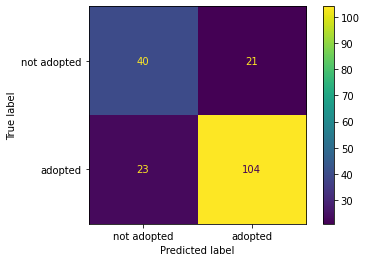

In [24]:
# Check out the confusion matrix for test set
# Note the display labels to make it easy to read!
plot_confusion_matrix(dt, X_test, y_test, display_labels=['not adopted', 'adopted']);

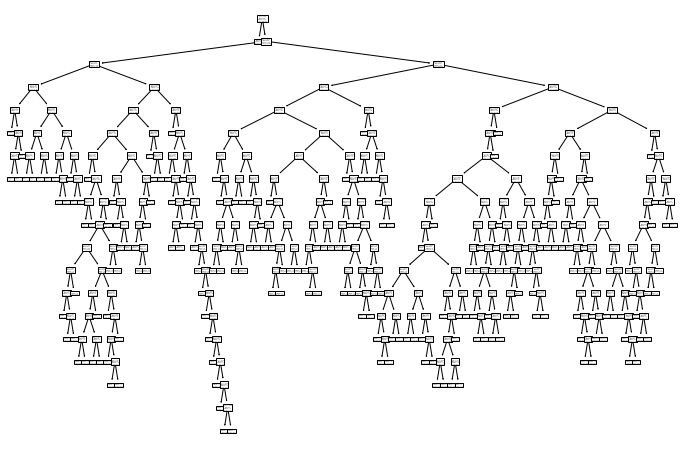

In [25]:
# Nice trick! We can use sklearn to visualize our tree
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(dt, ax=ax);

## The Biggest Issue with Decision Trees?

> ## Decision trees are SUPER prone to overfitting!

The image above is a good visual to represent an overfit tree.  Let's look at the train accuracy.

In [26]:
dt.score(X_train, y_train)

0.9626168224299065

Let's compare it to the test set:

In [27]:
dt.score(X_test, y_test)

0.7659574468085106

That's a big drop-off!

### Issue: Bias-Variance with Decision Trees

The CART algorithm will repeatedly partition data into smaller and smaller subsets until those final subsets are homogeneous in terms of the outcome variable. In practice this often means that the final subsets (known as the leaves of the tree) each consist of only one or a few data points. 

This results in low-bias, high variance trees.


### THUS: Decision trees are very sensitive to training data

Let's fit two trees based on two different samples of the data, and look at the difference.

(We'll set `max_depth=2` so we can better read our trees)

In [28]:
dt_samp1 = DecisionTreeClassifier(max_depth=2)

X_tr_sample_1 = X_train.sample(100, random_state=1)
y_tr_sample_1 = y_train[X_tr_sample_1.index]

dt_samp1.fit(X_tr_sample_1, y_tr_sample_1)

DecisionTreeClassifier(max_depth=2)

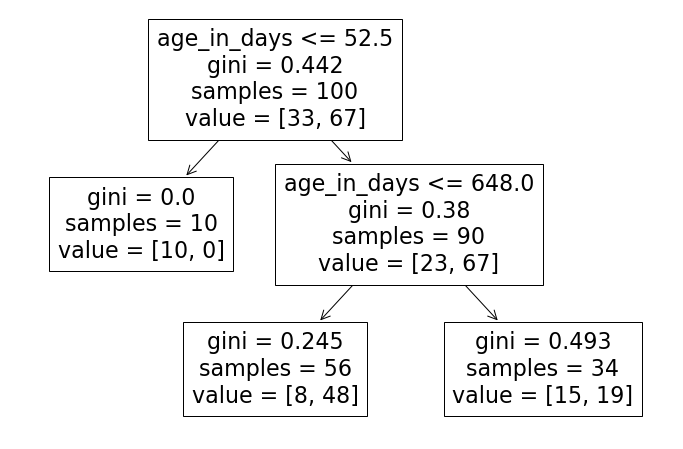

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(dt_samp1, ax=ax, feature_names=X_train.columns);

In [30]:
dt_samp2 = DecisionTreeClassifier(max_depth=2)

X_tr_sample_2 = X_train.sample(90, random_state=42)
y_tr_sample_2 = y_train[X_tr_sample_2.index]

dt_samp2.fit(X_tr_sample_2, y_tr_sample_2)

DecisionTreeClassifier(max_depth=2)

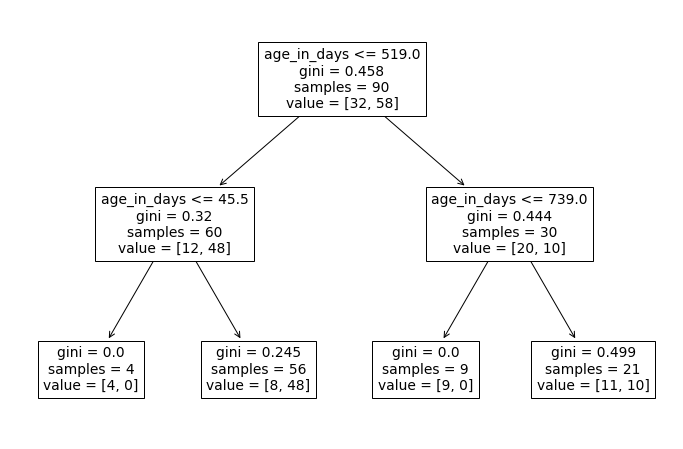

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(dt_samp2, ax=ax, feature_names=X_train.columns);

### Issue: Greediness

Decision trees will always split on the features with the most advantageous split. 

Take the above example.  The algorithm is almost exclusively using the `age_in_days` feature, potentially obscuring more-valuable information in `is_female` or `is_dog` 

We will see how to overcome greediness - making these models care about other features that can be useful - with Random Forests (Topic 30).

### Solution: Stopping Criterion, aka Pruning Hyperparameters

The recursive binary splitting procedure described above needs to know when to stop splitting as it works its way down the tree with the training data.

`min_samples_leaf`: The most common stopping procedure is to use a minimum count on the number of training instances assigned to each leaf node. If the count is less than some minimum then the split is not accepted and the node is taken as a final leaf node.

`max_leaf_nodes` : Reduce the number of leaf nodes

`max_depth` : Reduce the depth of the tree to build a generalized tree.

`min_impurity_split` : A node will split if its impurity is above the threshold, otherwise it is a leaf.


Typically these _hyper-parameters_ are based on *cross validation results* to determine the best values in general.

### `max_depth`

Let's try limiting the depth (by default the limit is `None`, i.e. unlimited depth):

In [32]:
# Start with a max depth of 10
dt = DecisionTreeClassifier(max_depth=10)

dt.fit(X_train, y_train)

print(f'Train Accuracy: {dt.score(X_train, y_train)}')
print(f'Test Accuracy: {dt.score(X_test, y_test)}')
# test accuracy improved 

Train Accuracy: 0.9092122830440588
Test Accuracy: 0.7872340425531915


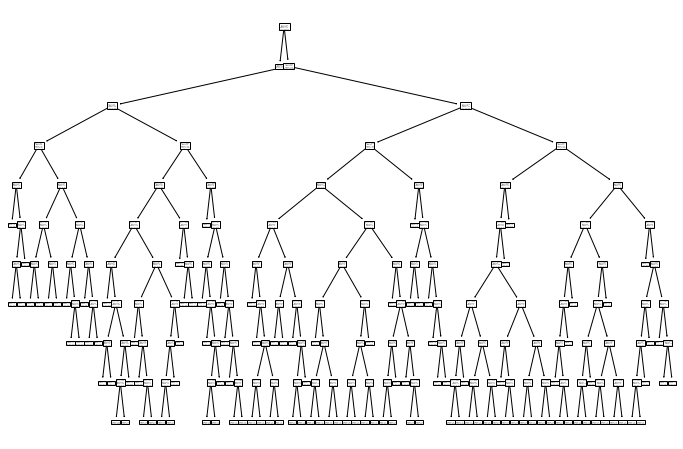

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(dt, ax=ax);

In [34]:
# Now a max depth of 5
dt = DecisionTreeClassifier(max_depth=5)

dt.fit(X_train, y_train)

print(f'Train Accuracy: {dt.score(X_train, y_train)}')
print(f'Test Accuracy: {dt.score(X_test, y_test)}')

Train Accuracy: 0.8170894526034713
Test Accuracy: 0.7712765957446809


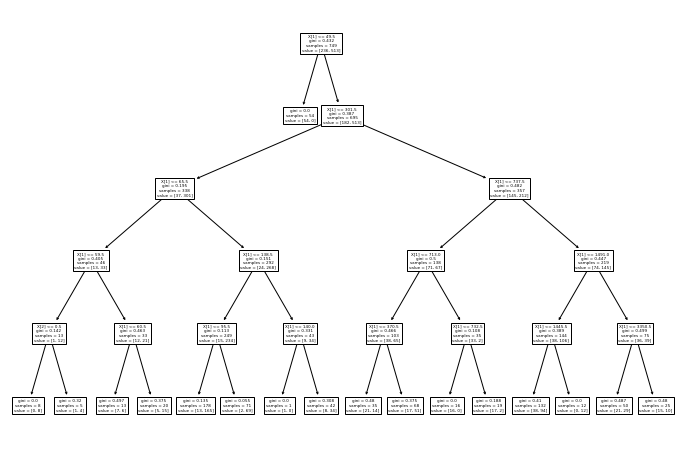

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(dt, ax=ax);

In [36]:
# Now a max depth of 1
dt = DecisionTreeClassifier(max_depth=1)

dt.fit(X_train, y_train)

print(f'Train Accuracy: {dt.score(X_train, y_train)}')
print(f'Test Accuracy: {dt.score(X_test, y_test)}')

Train Accuracy: 0.7570093457943925
Test Accuracy: 0.75


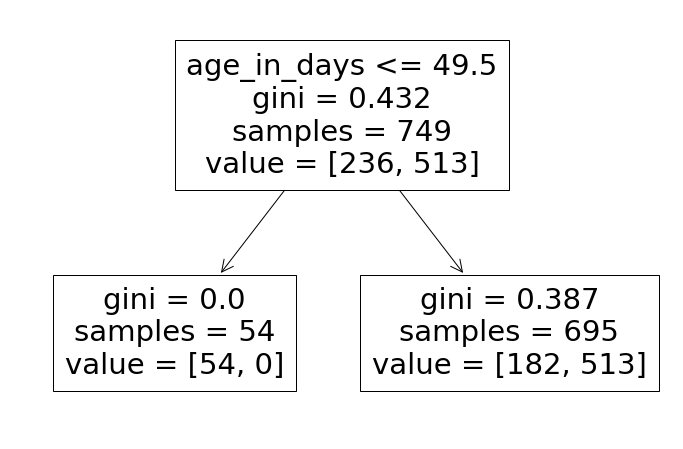

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(dt, ax=ax, 
          feature_names=X_train.columns); #adding this since we can read it now!

### `min_samples_leaf`

Let's try limiting minimum samples per leaf (by default the limit is `1`, i.e. a leaf node can have as few as 1 sample in it):

In [38]:
# Start with 5
dt = DecisionTreeClassifier(min_samples_leaf=5)

dt.fit(X_train, y_train)

print(f'Train Accuracy: {dt.score(X_train, y_train)}')
print(f'Test Accuracy: {dt.score(X_test, y_test)}')

Train Accuracy: 0.8718291054739653
Test Accuracy: 0.7978723404255319


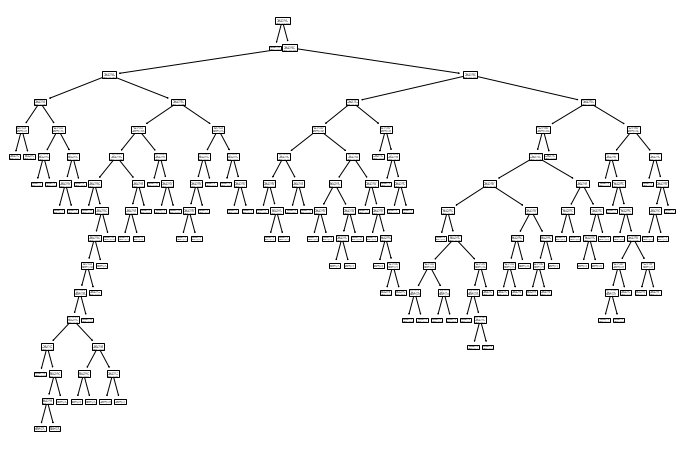

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(dt, ax=ax);

In [40]:
# Then 10
dt = DecisionTreeClassifier(min_samples_leaf=10)

dt.fit(X_train, y_train)

print(f'Train Accuracy: {dt.score(X_train, y_train)}')
print(f'Test Accuracy: {dt.score(X_test, y_test)}')

Train Accuracy: 0.8384512683578104
Test Accuracy: 0.8085106382978723


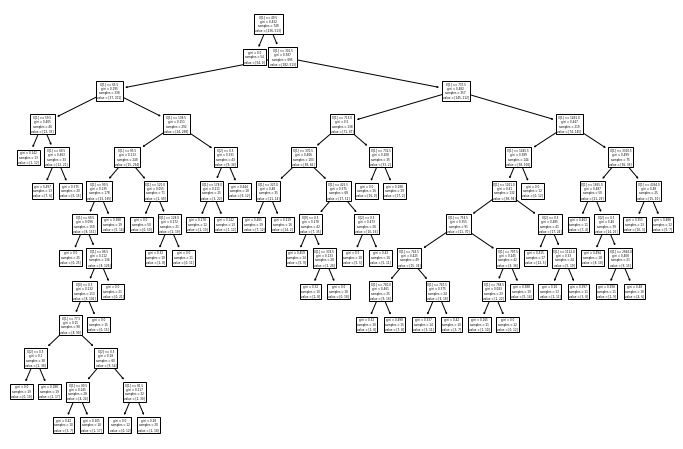

In [41]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(dt, ax=ax);

![](https://miro.medium.com/max/1136/1*3MDxpY_pIMs0yb4dc55KpQ.jpeg)

We played around with some hyperparameters in the above trees, and they can have a huge impact! We'll explore using a Grid Search tomorrow, which will provide a way to programmatically and systematically decide which hyperparameters are best.

# Feature Importances

The fitted tree has an attribute called `ct.feature_importances_`. What does this mean? Roughly, the importance of a feature is a sort of weighted average of the impurity decrease at internal nodes that make use of the feature. The weighting comes from the number of samples that depend on the relevant nodes.

> "The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance." -- See [`sklearn`'s documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_).

In [42]:
dt = DecisionTreeClassifier(max_depth=8)
dt.fit(X_train, y_train)

print(f'Train Accuracy: {dt.score(X_train, y_train)}')
print(f'Test Accuracy: {dt.score(X_test, y_test)}')
print('*' * 10)

for fi, feature in zip(dt.feature_importances_, X_train.columns):
    print(f'{feature}: {fi}')

Train Accuracy: 0.8731642189586115
Test Accuracy: 0.8031914893617021
**********
is_dog: 0.058922133732037266
age_in_days: 0.895657235560273
is_female: 0.045420630707689626


More on feature importances [here](https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3).

# Conclusions

- The decision tree is a "white-box" type of ML algorithm. It shares internal decision-making logic, which is not available in the black-box type of algorithms such as Neural Network.
- Its training time is faster compared to other algorithms such as neural networks.
- The decision tree is a non-parametric method, which does not depend upon probability distribution assumptions.
- Decision trees can handle high-dimensional data with good accuracy.

## Pros

- Easy to interpret and visualize
- Can easily capture non-linear patterns
- Require little data preprocessing from the user (no need to normalize/scale data)
- Can be used for feature engineering, such as variable selection and predicting missing values 
- Make no assumptions about distribution because its non-parametric

## Cons

- Sensitive to noisy data - easily overfits to noisy data
    - Small variations (or variance) in data can result in a completely different decision tree. This can be reduced by bagging and boosting algorithms (still to come in this phase)
- Decision trees are biased with imbalanced datasets, so it is recommended that you balance out the dataset before creating the decision tree.